In [1]:
import sympy
import sympy.physics.mechanics as mech

mech.init_vprinting()
frame_e = mech.ReferenceFrame('e')
t = sympy.symbols('t')
m, g, rho, S, a, b, c, d, epsilon = sympy.symbols('m, g, rho, S, a, b, c, d, epsilon', real=True)
J_xx, J_yy, J_zz, J_zx = sympy.symbols('J_xx, J_yy, J_zz, J_zx', real=True)
chi, gamma, mu, V, alpha, beta, T, P, Q, R, x, y, z = mech.dynamicsymbols('chi, gamma, mu, V, alpha, beta, T, P, Q, R, x, y, z', real=True)
L, M, N, X, Y, Z = mech.dynamicsymbols('L, M, N, X, Y, Z')
delta_a, delta_e, delta_r = mech.dynamicsymbols('delta_a, delta_e, delta_r')
frame_w = frame_e.orientnew('w', 'Body', (chi, gamma, mu), '321')
frame_b = frame_w.orientnew('b', 'Body', (-beta, alpha, 0), '321')
frame_t = frame_b.orientnew('b', 'Body', (epsilon, 0, 0), '231')
frame_b.set_ang_vel(frame_e, P*frame_b.x + Q*frame_b.y + R*frame_b.z)

omega_ew = frame_b.ang_vel_in(frame_e) + frame_w.ang_vel_in(frame_b)
kin_rot = omega_ew - frame_w.ang_vel_in(frame_e)

frame_w.set_ang_vel(frame_e, omega_ew)

C_L0, C_La, C_D0, k_D, C_Sb, C_la, C_m0, C_ma, C_me, C_nr = sympy.symbols('C_L0, C_La, C_D0, k_D, C_Sb, C_la, C_m0, C_ma, C_me, C_nr ')

C_L = C_L0 + C_La*alpha
C_D = C_D0 + k_D*C_L**2
C_S = C_Sb*beta

C_l = C_la*delta_a
C_m = C_m0 + C_ma*alpha + C_me*delta_e
C_n = C_nr*delta_r

q = rho*S*V**2/2
F_A = q*(-C_D*frame_w.x + C_L*frame_w.y - C_S*frame_w.z)
F_T = T*frame_b.x
F_W = m*g*frame_e.z
F_full = F_A + F_T + F_W

F_sol = {
    X: F_full.dot(frame_w.x),
    Y: F_full.dot(frame_w.y),
    Z: F_full.dot(frame_w.z)
}

F_w = X*frame_w.x + Y*frame_w.y + Z*frame_w.z

M_A = q*(a*C_l*frame_b.x + b*C_m*frame_b.y + c*C_n*frame_b.z)
M_T = T*d*frame_b.y
M_full = M_A + M_T

M_sol = {
    L: M_full.dot(frame_b.x),
    M: M_full.dot(frame_b.y),
    N: M_full.dot(frame_b.z)
}

M_b = L*frame_b.x + M*frame_b.y + N*frame_b.z


point_o = mech.Point('o')
point_o.set_vel(frame_e, 0)


point_p = point_o.locatenew('p', x*frame_e.x + y*frame_e.y + z*frame_e.z)
point_p.set_vel(frame_e, V*frame_w.x)
point_p.set_vel(frame_b, 0)

body = mech.RigidBody('body', point_p, frame_b, m, (mech.inertia(frame=frame_b, ixx=J_xx, iyy=J_yy, izz=J_zz, izx=J_zx), point_p))

In [2]:
frame_b.ang_vel_in(frame_e)

In [3]:
sol_rot = sympy.solve(kin_rot.to_matrix(frame_w), [chi.diff(t), gamma.diff(t), mu.diff(t)], simplify=True)
sol_rot

In [4]:
V_sol = sympy.sqrt(x.diff(t)**2 + y.diff(t)**2 + z.diff(t)**2)
gamma_sol = sympy.atan(-z.diff(t)/sympy.sqrt(x.diff(t)**2 + y.diff(t)**2))
chi_sol = sympy.atan(y.diff(t)/x.diff(t))

In [5]:
V_w = V*frame_w.x
sympy.atan(V_w.dot(frame_e.y)/ V_w.dot(frame_e.x)).simplify()

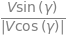

In [6]:
-V_w.dot(frame_e.z)/ sympy.sqrt(V_w.dot(frame_e.x)**2 + V_w.dot(frame_e.y)**2).simplify()

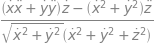

In [7]:
gamma_sol.diff(t).simplify()

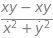

In [8]:
chi_sol.diff(t).simplify()

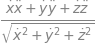

In [9]:
V_sol.diff(t).simplify()

In [10]:
LM = body.linear_momentum(frame_e)
LM_dot = LM.diff(t, frame_w) + frame_w.ang_vel_in(frame_e).cross(LM)
LM_dot = LM_dot.applyfunc(lambda x: x.simplify().expand())
LM_dot.to_matrix(frame_w)

⎡                                  m⋅V̇                                  ⎤
⎢                                                                       ⎥
⎢                 -m⋅P⋅V⋅sin(α) + m⋅R⋅V⋅cos(α) + m⋅V⋅β̇                  ⎥
⎢                                                                       ⎥
⎣m⋅P⋅V⋅sin(β)⋅cos(α) - m⋅Q⋅V⋅cos(β) + m⋅R⋅V⋅sin(α)⋅sin(β) + m⋅V⋅cos(β)⋅α̇⎦

In [11]:
H = body.angular_momentum(point_p, frame_e)
H_dot = H.diff(t, frame_b) + frame_b.ang_vel_in(frame_e).cross(H)
H_dot = H_dot.applyfunc(lambda x: x.simplify().expand())
H_dot.to_matrix(frame_b)

⎡Jₓₓ⋅Ṗ - J_yy⋅Q⋅R + J_zx⋅P⋅Q + J_zx⋅Ṙ + J_zz⋅Q⋅R ⎤
⎢                                                ⎥
⎢                         2         2            ⎥
⎢Jₓₓ⋅P⋅R + J_yy⋅Q̇ - J_zx⋅P  + J_zx⋅R  - J_zz⋅P⋅R ⎥
⎢                                                ⎥
⎣-Jₓₓ⋅P⋅Q + J_yy⋅P⋅Q - J_zx⋅Q⋅R + J_zx⋅Ṗ + J_zz⋅Ṙ⎦

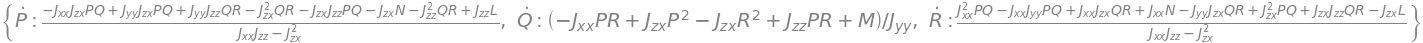

In [12]:
sol_ang = sympy.solve((H_dot - M_b).to_matrix(frame_b), [P.diff(t), Q.diff(t), R.diff(t)], simplify=True)
sol_ang

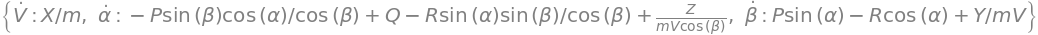

In [13]:
sol_trans = sympy.solve((LM_dot - F_w).to_matrix(frame_w), [V.diff(t), alpha.diff(t), beta.diff(t)])
sol_trans

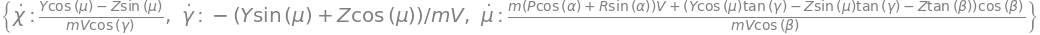

In [14]:
sol_rot_simp = {}
sol_rot_simp[chi.diff(t)] = sol_rot[chi.diff(t)].subs(sol_trans).simplify()
sol_rot_simp[mu.diff(t)] = sol_rot[mu.diff(t)].subs(sol_trans).simplify().expand().simplify()
sol_rot_simp[gamma.diff(t)] = sol_rot[gamma.diff(t)].subs(sol_trans).simplify()
sol_rot_simp

In [15]:
states = [x, y, z, V, alpha, beta, gamma, chi, mu, P, Q, R]
state_dot = {}
state_dot[x] = point_p.vel(frame_e).dot(frame_e.x)
state_dot[y] = point_p.vel(frame_e).dot(frame_e.y)
state_dot[z] = point_p.vel(frame_e).dot(frame_e.z)
state_dot[V] = sol_trans[V.diff(t)]
state_dot[alpha] = sol_trans[alpha.diff(t)]
state_dot[beta] = sol_trans[beta.diff(t)]
state_dot[gamma] = sol_rot_simp[gamma.diff(t)]
state_dot[chi] = sol_rot_simp[chi.diff(t)]
state_dot[mu] = sol_rot_simp[mu.diff(t)]
state_dot[P] = sol_ang[P.diff(t)]
state_dot[Q] = sol_ang[Q.diff(t)]
state_dot[R] = sol_ang[R.diff(t)]

x_vect = sympy.Matrix(states)
x_dot_vect = sympy.Matrix([ state_dot[xi] for xi in states ])
sympy.Eq(x_vect.diff(t),  x_dot_vect)

      ⎡                                            V⋅cos(χ)⋅cos(γ)            
      ⎢                                                                       
      ⎢                                            V⋅sin(χ)⋅cos(γ)            
      ⎢                                                                       
      ⎢                                               -V⋅sin(γ)               
      ⎢                                                                       
      ⎢                                                   X                   
      ⎢                                                   ─                   
      ⎢                                                   m                   
      ⎢                                                                       
      ⎢                           P⋅sin(β)⋅cos(α)       R⋅sin(α)⋅sin(β)       
      ⎢                         - ─────────────── + Q - ─────────────── + ────
⎡ẋ⎤   ⎢                                cos(β)      

In [16]:
sol_rot